In [1]:
import sys
sys.path.append('..')

import csv
import os
import torch
import librosa
import numpy as np
import librosa.display
from pypesq import pesq
from pystoi import stoi
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from IPython.display import Audio
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import euclidean
from dataset.HiFiGanDataset import HiFiGanDataset
from hparams.HiFiGanHParams import HiFiGanHParams as hps
from inference_handlers.HiFiGanInferenceHandler import HiFiGanInferenceHandler
from inference_handlers.Tacotron2InferenceHandler import Tacotron2InferenceHandler

In [2]:
tacotron2_ckpt_path = "/train_path/working_models/tacotron2_en"
hifigan_ckpt_path = "/train_path/working_models/hifigan"
metadata_path = "/train_path/LJSpeech-1.1/metadata.csv"
base_wavs_path = "/train_path/LJSpeech-1.1/wavs/"
cleaners = ["english_cleaners"]

sr = 22050

In [3]:
with open(metadata_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="|")
        data = list(reader)[:50]

pairs = [
        {
            'path': f'{base_wavs_path}{p[0]}.wav',
            'text': p[1]
        }
        for p in data
    ]

In [4]:
# Initialize Tacotron2
tacotron2 = Tacotron2InferenceHandler(
    tacotron2_ckpt_path,
    use_cuda=True,
)

# Initialize HiFi-GAN
hifigan = HiFiGanInferenceHandler(
    hifigan_ckpt_path,
    use_cuda=True
)

def infer(text):
    # Tacotron2 synthesis
    tacotron2_mel, alignments = tacotron2.infer_e2e(
        text,
        cleaners=cleaners,
    )

    # HiFi-GAN synthesis
    wav, sr = hifigan.infer(tacotron2_mel)
    
    return wav

def read_sentence(path):
    wav, _ = HiFiGanDataset._load_wav(path)
    return wav

Removing weight norm...


In [5]:
def compute_mcd(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    min_len = min(len(ref_audio), len(synth_audio))
    ref_audio = ref_audio[:min_len]
    synth_audio = synth_audio[:min_len]

    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    mcd = np.mean(np.sqrt(2 * np.sum((mfcc_ref - mfcc_synth)**2, axis=0)))
    return mcd


def compute_mcd_dtw(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose MFCC matrices for DTW alignment (time-major format)
    mfcc_ref = mfcc_ref.T
    mfcc_synth = mfcc_synth.T
    
    # Compute DTW distance between MFCC sequences
    _, d = fastdtw(mfcc_ref, mfcc_synth, dist=euclidean)
    
    # Compute MCD-DTW as the square root of the mean of DTW distances
    mcd_dtw = np.sqrt(np.mean(d))
    
    return mcd_dtw


def compute_stoi_score(ref, syn, sr):

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = stoi(ref, syn, sr, extended=False)
    return score


def compute_pesq_score(ref, syn, sr):
    target_sr = 8000
    ref = librosa.resample(ref.astype('float32'), sr, target_sr)
    syn = librosa.resample(syn.astype('float32'), sr, target_sr)

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = pesq(ref, syn, target_sr)
    return score


def compute_pitch(y, sr):  
    # Use Harmonic/Percussive Source Separation (HPSS)
    harmonic, percussive = librosa.effects.hpss(y.astype('float32'))

    # Extract pitch using librosa's piptrack
    pitches, magnitudes = librosa.core.piptrack(y=harmonic, sr=sr, fmin=librosa.note_to_hz('E2'), fmax=librosa.note_to_hz('C5'))

    # Extract the pitch values from the piptrack output
    pitch = np.zeros(pitches.shape[1])
    for t in range(pitches.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch[t] = pitches[index, t] if magnitudes[index, t] > 0 else np.nan

    return pitch

In [6]:
stats = []

for pair in pairs:
    syn_wav = infer(pair['text'])
    real_wav = read_sentence(pair['path'])
    
    pitch_real = compute_pitch(real_wav, sr)
    pitch_syn = compute_pitch(syn_wav, sr)
    mcd = compute_mcd(real_wav, syn_wav)
    mcd_dtw = compute_mcd_dtw(real_wav, syn_wav)
    stoi_score = compute_stoi_score(real_wav, syn_wav, sr)
    pesq_score = compute_pesq_score(real_wav, syn_wav, sr)
    
    stats.append(dict(
        pitch_real=pitch_real,
        pitch_syn=pitch_syn,
        mcd=mcd,
        mcd_dtw=mcd_dtw,
        stoi_score=stoi_score,
        pesq_score=pesq_score
    ))


Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.
Terminated by gate.


In [7]:
# Extract arrays of values into NumPy arrays
pitch_real_values = np.concatenate([d['pitch_real'] for d in stats])
pitch_syn_values = np.concatenate([d['pitch_syn'] for d in stats])

pitch_real_values = pitch_real_values[~np.isnan(pitch_real_values)]
pitch_syn_values = pitch_syn_values[~np.isnan(pitch_syn_values)]

mcd_values = np.array([d['mcd'] for d in stats])
mcd_dtw_values = np.array([d['mcd_dtw'] for d in stats])
stoi_score_values = np.array([d['stoi_score'] for d in stats])
pesq_score_values = np.array([d['pesq_score'] for d in stats])

# Compute averages and standard deviations using NumPy
average_pitch_real = np.mean(pitch_real_values)
std_dev_pitch_real = np.std(pitch_real_values)

average_pitch_syn = np.mean(pitch_syn_values)
std_dev_pitch_syn = np.std(pitch_syn_values)

average_mcd = np.mean(mcd_values)
std_dev_mcd = np.std(mcd_values)

average_mcd_dtw = np.mean(mcd_dtw_values)
std_dev_mcd_dtw = np.std(mcd_dtw_values)

average_stoi_score = np.mean(stoi_score_values)
std_dev_stoi_score = np.std(stoi_score_values)

average_pesq_score = np.mean(pesq_score_values)
std_dev_pesq_score = np.std(pesq_score_values)

# Print or use the results
print("Average and Standard Deviation Results:")
print(f"Pitch Real - Average: {average_pitch_real}, Std Dev: {std_dev_pitch_real}")
print(f"Pitch Syn - Average: {average_pitch_syn}, Std Dev: {std_dev_pitch_syn}")
print(f"MCD - Average: {average_mcd}, Std Dev: {std_dev_mcd}")
print(f"MCD DTW - Average: {average_mcd_dtw}, Std Dev: {std_dev_mcd_dtw}")
print(f"STOI Score - Average: {average_stoi_score}, Std Dev: {std_dev_stoi_score}")
print(f"PESQ Score - Average: {average_pesq_score}, Std Dev: {std_dev_pesq_score}")

Average and Standard Deviation Results:
Pitch Real - Average: 321.2434991998647, Std Dev: 97.26245007897955
Pitch Syn - Average: 341.84564498249813, Std Dev: 118.7266564898545
MCD - Average: 199.6830672344232, Std Dev: 45.969101395559285
MCD DTW - Average: 12.057744748122678, Std Dev: 2.1027935023754267
STOI Score - Average: 0.2569644872682098, Std Dev: 0.1437529295990454
PESQ Score - Average: 1.100290538072586, Std Dev: 0.2527692931326007


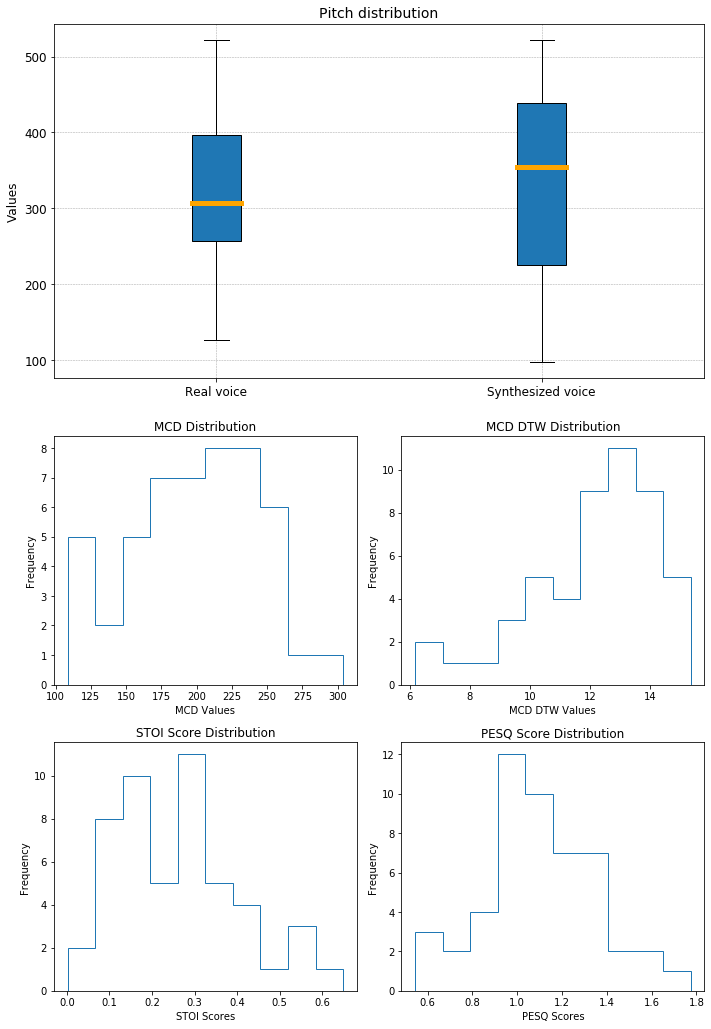

In [8]:
# Create a figure
fig = plt.figure(figsize=(10, 15))

gs = gridspec.GridSpec(3, 2, height_ratios=[1, 0.7, 0.7])

# Plot Pitch Real and Pitch Syn (wider plot)
ax1 = fig.add_subplot(gs[0, :])
box = ax1.boxplot([pitch_real_values, pitch_syn_values], labels=['Real voice', 'Synthesized voice'], patch_artist=True)
ax1.set_title('Pitch distribution', fontsize=14)
ax1.set_ylabel('Values', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
for median in box['medians']:
    median.set(linewidth=5, color='orange')

# Plot MCD
ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(mcd_values, bins=10, histtype='step')
ax2.set_title('MCD Distribution')
ax2.set_xlabel('MCD Values')
ax2.set_ylabel('Frequency')

# Plot MCD DTW
ax3 = fig.add_subplot(gs[1, 1])
ax3.hist(mcd_dtw_values, bins=10, histtype='step')
ax3.set_title('MCD DTW Distribution')
ax3.set_xlabel('MCD DTW Values')
ax3.set_ylabel('Frequency')

# Plot STOI Score
ax4 = fig.add_subplot(gs[2, 0])
ax4.hist(stoi_score_values, bins=10, histtype='step')
ax4.set_title('STOI Score Distribution')
ax4.set_xlabel('STOI Scores')
ax4.set_ylabel('Frequency')

# Plot PESQ Score
ax5 = fig.add_subplot(gs[2, 1])
ax5.hist(pesq_score_values, bins=10, histtype='step')
ax5.set_title('PESQ Score Distribution')
ax5.set_xlabel('PESQ Scores')
ax5.set_ylabel('Frequency')

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show plot
plt.show()